In [1]:
## Plotting Savgol smoothed, first, second and extrema using the second (newest) time step iteration where 
    # tstep = StepProcessTime (or ElapsedProcessTime, depending on the tool)
    # Currently testing 22 STI, step 6, wavelength C516
import pandas as pd
import glob
import os
import numpy as np
import dask.dataframe as dd
from datetime import datetime,timedelta
import time
import matplotlib.pyplot as plt
from scipy.signal import find_peaks,savgol_filter
from scipy import interpolate, stats
import seaborn as sns
from tqdm import tqdm                       # For progress bar, yay!


In [2]:
# Retrieving Metro Data from .txt files
mfile = []
metro = {}
metro_cols = ['waferscribe','ext_mv'] # ext_mv is the column containing the metro parameter values
print('Reading Metro Data')
for filename in glob.glob("metro/22*"): # Reading txt files
        # Only reading the previously defined columns with the filename as a key
    metro[filename[6:-4]] = pd.read_csv(filename,usecols=metro_cols)[metro_cols] # type(metro) = dict
        # Create index of filename strings ...Maybe I don't need this...
    mfile.append(filename[6:-4])
        # Turning into DataFrame to help with Memeory Errors
    met = pd.concat(metro.values(),ignore_index=True) # type(met) = pandas.core.frame.DataFrame
    print(f'\t{filename} Data Finished')

    # Trim down 'met' to relevant metro parameter values (This is broken down due to previous error troubleshooting, can be condensed)
paramVal = met['ext_mv']          # type(paramVal)    = pandas.core.series.Series
paramBool = met[paramVal%1==0]    # type(paramBool)   = pandas.core.frame.DataFrame
dropParam = paramBool.index       # type(dropParam)   = pandas.core.indexes.numeric.Int64Index
    # Removing values with decimal values = 0
met.drop(dropParam, inplace=True) 
MetroWafers = met.waferscribe     # type(MetroWafers) = pandas.core.series.Series

Reading Metro Data
	metro\22STIINT.txt Data Finished


In [12]:
# Retrieving OES Data from the .csv files, takes MUCH longer, retrieving specfic columns helps
ofile = []
oes = {}
data = {}
    # Less 22STI columns to prevent the MemoryError from popping up
oes_cols = ['WAFER_SCRIBE','StepProcessTime','StepID','OES_CO483','OES_C516','OES_CN387','OES_Si251','OES_Si288'] # 22STI
    # Full 22STI columns that will yield a MemoryError UNLESS, only a single 22STI file is being read
#oes_cols = ['WAFER_SCRIBE','RunStartTime','TimeStamp','StepID','OES_BCl272','OES_C516','OES_CN387','OES_CO483','OES_F703','OES_H656','OES_O777','OES_OH309','OES_Si251','OES_Si288'] # 22STI
    # GHContact Columns
#oes_cols = ['WAFER_SCRIBE','RunStartTime','TimeStamp','StepID','OESIB1','OESIB2','OESIB3','OESIB4','OESIB5','OESIB6','OESIB7','OESIB8'] # GHContact
    # Note: OES_* corresponds to an AMAT tool(22STI), OESIB* corresponds to a LAM tool(GHContact)
print('Reading OES Data')
    # 5030-22 STI INTEGRATED DRY ETCH_2 
    # 3500-GH CONTACT OXIDE DRY ETCH_1.csv
for filename in glob.glob("oes/5030-22 STI INTEGRATED DRY ETCH_*.csv"): 
        # Reading OES data with previously defined columns, parsing dates and infering format
    oes[filename[4:-4]] = pd.read_csv(filename, usecols=oes_cols)[oes_cols]  # type(oes) = dict
        # Create index of filename strings ...Maybe I don't need this...
    ofile.append(filename[4:-4]) 
        # Turning into DataFrame to help with Memeory Errors
    data = pd.concat(oes.values(),ignore_index=True)                         # type(data) = pandas.core.frame.DataFrame
    print(f'\t{filename} Data Finished')

    # Array of unique wafers within an OES data set
UniqueWaferArray = data.WAFER_SCRIBE.unique()                                # type(UniqueWafers) = numpy.ndarray
    # An inverted bool array of whether those unique wafers match any wafers in the metro data 
nonWafers = np.isin(UniqueWaferArray,list(MetroWafers),invert=True)          # type(nonWafers) = numpy.ndarray
i = np.where(nonWafers)[0]                                                   # type(i) = numpy.ndarray
    # Identify the wafers that don't have a metro parameter, used in NEXT loop
WaferScribe = (UniqueWaferArray[i])                                          # type(WaferScribe) = numpy.ndarray

Reading OES Data
	oes\5030-22 STI INTEGRATED DRY ETCH_2.csv Data Finished
	oes\5030-22 STI INTEGRATED DRY ETCH_3.csv Data Finished
	oes\5030-22 STI INTEGRATED DRY ETCH_4.csv Data Finished


In [13]:
print('Trimming Down Data to Only Metro-Matching Wafers') 
    # Having just the data for the wafers that have available metro parameters removes the possibility of accidentally using 
    # data that has no associated metro parameter. Including that data may skew the model building and therefore the results.
indexNames = []
for x in tqdm(WaferScribe):                # For a wafer in the array of wafers that don't have a metro parameter,
    WaferScribeData = data['WAFER_SCRIBE'] # Just the OES data column containing wafers that don't have a metro parameter
    dataindex = data[WaferScribeData == x] # Entire OES data of the wafers that don't have a metro parameter
    indexNames = dataindex.index           # An index of the OES data that doesn't have a metro parameter
    data.drop(indexNames , inplace=True)   # Removing that data that doesn't have a metro parameter
print('\tDone!')
    # Creating NEW unique wafer array for a loop turning date/time format to seconds and the matplotlib loop
UniqueWafers = data.WAFER_SCRIBE.unique()  # type(UniqueWafers) = numpy.ndarray

  0%|                                                                                          | 0/575 [00:00<?, ?it/s]

Trimming Down Data to Only Metro-Matching Wafers


100%|████████████████████████████████████████████████████████████████████████████████| 575/575 [02:32<00:00,  3.77it/s]

	Done!


In [14]:
print('Creating Dict of Wafers & Processing Dates into Seconds')
    # This dict with enumerated wafers provides an easy way to reference and present a single wafer, or loop through many 
    # wafers. Creating this dict and translating the time stamps to seconds format is done in the same enumeration.
t_sec = {}
Wafer = {}
    # Create a dict of empty DataFrames with keys of wafers
DataFrameDict = {elem : pd.DataFrame for elem in UniqueWafers}
for i,key in enumerate(tqdm(DataFrameDict.keys())):                      # For a number and waferscribe
    Wafer[i] = pd.DataFrame.from_dict(data[:][data.WAFER_SCRIBE == key]) # Create a wafers DataFrame with numerical keys of the time, step ID and OES data
    ProcessTime = [col for col in Wafer[i].columns if 'Process' in col]  # Identify the column name for elapsed time in a process step
    t_sec[i] = Wafer[i][ProcessTime].dropna()                            # Remove rows containing NaN where a process is beginning/ending
print('\tDone!')
OES_col = [col for col in Wafer[i].columns if 'OES' in col] # Create list of wavelengths present in wafer DataFrame
step = 6                                                    # Change this to explore other etch steps

 14%|███████████▌                                                                       | 7/50 [00:00<00:00, 67.96it/s]

Creating Dict of Wafers & Processing Dates into Seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 69.93it/s]

	Done!


__SGsmooth__: Filtered data of the wavelength intensities. This filtering is done to smooth the data in a way that increases the precision of the data without distorting the signal through a convolution where it fits a subset of data points, dictated by a `WinLen` of the number of coefficients, with a low degree polynomial, `POrder`. There's a cool visual on the wikipedia page. This technique was used instead of the interpolation because the the scipy.interpolation was generating plots with little to no features maintained, and when attempting to use a lower smoothing value, $s$, it'd break the function. I didn't explore that further, as the SavGol filter ended up working well, see Neale @ Work: 1/15. 

`array([ -2001.7248452 ,   8616.44195046,  -4515.35684091, -13334.40974041,
        -3328.43522538,  29266.48953755,  80267.99995941, 140349.51529582,
       191943.61345771, 232159.21793063, 254927.53841819, 259764.98462832,
       251359.06114005, 244264.90376492, 238800.90887436, 231190.1153954 ,
       225979.33230851, 227567.85251895, 238343.66017878, 255092.48522371,...`

__first, second__: Differentiating with the Savitzky Golay filter with the same window length and polynomial order as the smoothing filter. 

`array([ 3.57954085e+04, -7.20324064e+03, -1.44299396e+04, -8.36153846e+02,
        2.14287222e+04,  4.30173654e+04,  5.73845241e+04,  6.07870178e+04,
        4.96078146e+04,  2.86599853e+04,  6.90237577e+03, -5.62715487e+03,
       -6.11037656e+03, -4.49078188e+03, -5.15225739e+03, -5.27357549e+03,
       -3.51985447e+03,  1.27673826e+03,  1.23016682e+04,  2.13269713e+04,...`
       
`array([-6.65689639e+04, -2.23872572e+04,  5.44194839e+03,  1.97207240e+04,
        2.32511409e+04,  1.88352703e+04,  9.27518366e+03, -2.62704792e+03,
       -1.06064409e+04, -1.52783328e+04, -1.49973296e+04, -1.03321905e+04,
       -3.52199790e+03, -5.09671224e+02,  5.21503821e+02,  2.96995340e+03,
        5.64924951e+03,  7.09735292e+03,  5.81520012e+03,  2.44681309e+03,...`
        
__peaks__: Takes in a 1D array (second derivative values), and identify local maxima (extrema of the smoothed interpolation function). Output is the indices of the maxima with respect to an $x$ (time step) array. (Another option for another day, `find_peaks_cwt`, that identifies peaks in noisy data, but maybe I won't need it)

`array([ 4, 17, 27, 31, 52], dtype=int32)`

<IPython.core.display.Javascript object>


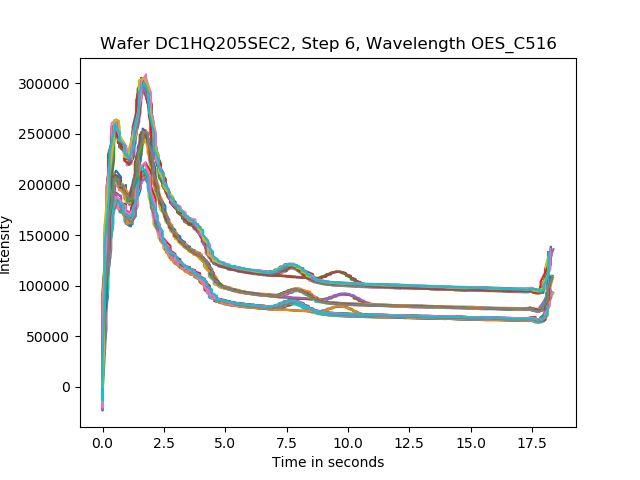

In [52]:
%matplotlib notebook
# Temporary, for my own understanding
peakTime = []
waferScribe = []
for x in range (len(UniqueWafers)):                            # Loop through all wafers
    #fig = plt.figure() # Comment out for single plot of all wafers OR don't comment for multiple plots with single wafer on it
    Tsteps = t_sec[x].loc[Wafer[x]['StepID']==step]            # Series of time in seconds for a given step
    x_int = np.linspace(Tsteps.iloc[0], Tsteps.iloc[-1], 100)  # Create linearly spaced array of 100 time steps
    for y in range(1,2):                                                                       # Loop through OES wavelengths
        plt.title(f"Wafer {UniqueWafers[x]}, Step {step}, Wavelength {OES_col[y]}")            # Plot Title
        WinLen = 15  # Window length:
        POrder = 5   # Polynomial order:
        Intensity = Wafer[x][OES_col[y]].loc[Wafer[x]['StepID']==step]                    # Intensities for a wavelength
        if Tsteps.values[-1] == 0.:                                                       # Check if final time step is zero 
            Tsteps.drop(Tsteps.tail(1).index,inplace=True)                                # Remove it, then
            Intensity.drop(Intensity.tail(len(Intensity)-len(Tsteps)).index,inplace=True) # Keep same length for plotting
        if len(Tsteps)!= len(Intensity):                                                  # For unequal arrays
            Intensity.drop(Intensity.tail(len(Intensity)-len(Tsteps)).index,inplace=True) # Remove the ending values
        #plt.plot(Tsteps,Intensity, label=f"{OES_col[y]}")                                       # OG Data
        SGsmooth = savgol_filter(Intensity,window_length=WinLen, polyorder = POrder, deriv = 0) # See above    
        plt.plot(Tsteps,SGsmooth, label=f"{UniqueWafers[x]}")                                   # Smoothed Data
        first = savgol_filter(Intensity,window_length=WinLen, polyorder = POrder, deriv = 1)    # See above  
        #plt.plot(Tsteps,first, label=f"1st {OES_col[y]}",linestyle = '--',color="tab:red")      # First Derivative Plot
        second = savgol_filter(Intensity,window_length=WinLen, polyorder = POrder, deriv = 2)   # See above  
        #plt.plot(Tsteps,second, label=f"2nd {OES_col[y]}",linestyle = ':',color="tab:green")    # Second Derivative Plot
        peaks, _ = find_peaks(second) #, height=5e2)                                               # See above  
        #peaks = peaks[np.concatenate(Tsteps.values[peaks], axis=None)>17.4]    # Remove peaks less than 4 seconds
        #peaks = peaks[np.concatenate(Tsteps.values[peaks], axis=None)<8]    # Remove peaks greater than 8 seconds
        #plt.plot(Tsteps.values[peaks], first[peaks], "x",color="tab:purple")                    # First Derivative Peaks
        #plt.plot(Tsteps.values[peaks], second[peaks], "x",color="tab:purple")                   # Second Derivative Peaks
        #plt.plot(Tsteps.values[peaks], SGsmooth[peaks], "x",color="tab:purple")                 # Smoothed Peaks
        
        try:    # Here to remedy the case of an empty array
            peakTime.append(np.concatenate(Tsteps.values[peaks[0]], axis=None)) # List containing etch time
            waferScribe.append(UniqueWafers[x])                                 # List with the wafer associated with that etch time
        except IndexError:
            pass
        
    plt.ylabel("Intensity")
    plt.xlabel("Time in seconds")
    #plt.legend()

Coefficient of Determination: 0.010467453726208362


<IPython.core.display.Javascript object>


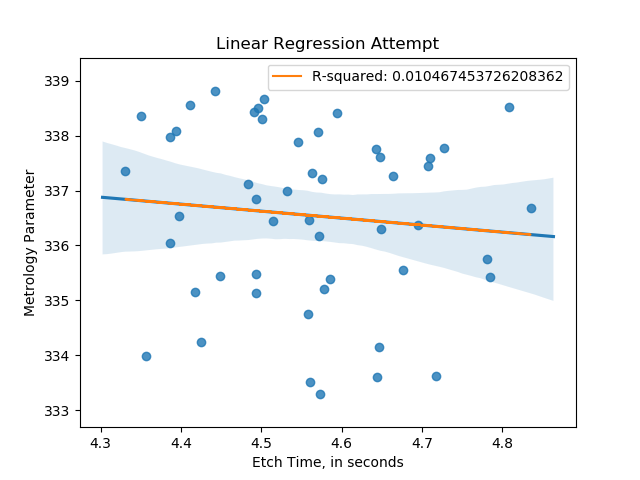

In [10]:
# Perform and present linear regression, matching etch time to metrology parameters for a wafer
etch_time = []
    # DataFrame of wafers and their associated metro parameter
wafer_param_time = met[['waferscribe','ext_mv']] 
    # Turning the two lists of wafers and etch times to a DataFrame
etch_time = pd.DataFrame({'waferscribe':waferScribe,'peaks':peakTime}) 
    # Joining the etch time and wafer parameter into a single DataFrame, matching up the etch and parameter to the correct wafer
result = pd.merge(etch_time, wafer_param_time, on = ['waferscribe'])
    # Performing a linear regression and calculating the slope, intercept, correlation coefficient, probability value, and standard error
slope, intercept, r_value, p_value, std_err = stats.linregress(x=result.peaks.astype('float'), y=result.ext_mv)
print(f"Coefficient of Determination: {r_value**2}")

    # Plotting Linear Regression
fig = plt.figure()
sns.regplot(x=result.peaks.astype('float'), y=result.ext_mv) # Includes a confidence interval display that I like
    # But won't calculate the R-squared value
plt.plot(result.peaks, result.peaks*slope+intercept, label = f"R-squared: {r_value**2}")  # Plots the linear regression again
plt.title("Linear Regression Attempt")
plt.ylabel("Metrology Parameter")
plt.xlabel("Etch Time, in seconds")
plt.legend()
plt.show()

### Here's where I'm playing around and getting familiar with correlation functions:
__pandas.Series.corr__: Computes a correlation with *other* Series. Takes in a Series and outputs a float. A method can be called, either Pearson, Kendall, Spearman or a callable function. 
 - Pearson: Within [-1:+1] measuring the linear correlation between two variables, where 0 is no correlation, -1 is a negative linear correlation +1 is a positive linear correlation. The Pearson correlation coefficient is the covariance(positive or negative depending on the tendency of the linear relationship, like a non-normalized version of the correlation coefficient) of the two variables divided by the product of their standard deviations.

|           |OES_CO483 | OES_C516 | OES_CN387 | OES_Si251 | OES_Si288
|-----------|----------|----------|-----------|-----------|----------
|OES_CO483  | 1.000000 | 0.167694 |  0.853307 |  0.917994 |  0.813568
|OES_C516   | 0.167694 | 1.000000 | -0.086855 | -0.138526 |  0.346425
|OES_CN387  | 0.853307 |-0.086855 |  1.000000 |  0.945755 |  0.663284
|OES_Si251  | 0.917994 |-0.138526 |  0.945755 |  1.000000 |  0.644521
|OES_Si288  | 0.813568 | 0.346425 |  0.663284 |  0.644521 |  1.000000

  - Kendall: Measures the ordinal association(relationship of rankings of ordered categories) between two measured quantities
  
|           |OES_CO483 | OES_C516 | OES_CN387 | OES_Si251 | OES_Si288
|-----------|----------|----------|-----------|-----------|----------
|OES_CO483  | 1.000000 |-0.129874 |  0.372038 |  0.225554 |  0.097983
|OES_C516   |-0.129874 | 1.000000 |  0.007445 | -0.705770 |  0.364580
|OES_CN387  | 0.372038 | 0.007445 |  1.000000 |  0.248132 |  0.130097
|OES_Si251  | 0.225554 |-0.705770 |  0.248132 |  1.000000 | -0.240706
|OES_Si288  | 0.097983 | 0.364580 |  0.130097 | -0.240706 |  1.000000

 - Spearman: Equal to the Pearson correlation between the rank values, assess monotonic relationships, less sensitive than Pearson due to the outliers being limited to its rank, rather than its value

|           |OES_CO483 | OES_C516 | OES_CN387 | OES_Si251 | OES_Si288
|-----------|----------|----------|-----------|-----------|----------
|OES_CO483  | 1.000000 |-0.281470 |  0.413025 |  0.432723 |  0.065206
|OES_C516   |-0.281470 | 1.000000 | -0.098767 | -0.740971 |  0.503524
|OES_CN387  | 0.413025 |-0.098767 |  1.000000 |  0.493433 |  0.128761
|OES_Si251  | 0.432723 |-0.740971 |  0.493433 |  1.000000 | -0.279335
|OES_Si288  | 0.065206 | 0.503524 |  0.128761 | -0.279335 |  1.000000

In [71]:
wavelengths = Wafer[x][OES_col[:]].loc[Wafer[x]['StepID']==step]
Pearson = wavelengths.corr(method = 'pearson')
Kendall = wavelengths.corr(method = 'kendall')
Spearman = wavelengths.corr(method = 'spearman')